# MarlimR3D - Comparisons

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

In [2]:
%matplotlib notebook

In [3]:
def demod_line(d, n):
    """Get inlined/broadside and demod ([real; real] to complex)."""
    return abs(getattr(d, n).data[::2, :, :] + 1j*getattr(d, n).data[1::2, :, :])

## Load published Marlim R3D data

In [4]:
data = xr.load_dataset('marlim_data.nc', engine='h5netcdf')

# Get offsets for plotting
offs = data.src_x[::2] - data.rec_x
offs /= 1e3

## Our results

In [5]:
egd = xr.load_dataset('results/marlim_emg3d.nc', engine='h5netcdf')
cst = xr.load_dataset('results/marlim_custEM_p2.nc', engine='h5netcdf')
ptg = xr.load_dataset('results/marlim_petgem.nc', engine='h5netcdf')
spg = xr.load_dataset('results/marlim_simpeg.nc', engine='h5netcdf')

for dat, name in zip([egd, cst, ptg, spg], ['emg3d', 'custEM', 'PETGEM', 'SimPEG']):
    print(f"\n= - = - =  : {name} {14*'= - '}=\n")
    for key in dat.attrs.keys():
        if key not in data.attrs.keys():
            print(f"{key:10} : {dat.attrs[key]}")


= - = - =  : emg3d = - = - = - = - = - = - = - = - = - = - = - = - = - = - =

date       : 2021-01-28T21:27:21.688203
extent     : x = 327426.0-453624.0; y = 7464458.2-7570039.8; z = -56648.0-65661.0
machine    : Laptop; i7-6600U CPU@2.6 GHz x4; 15.5 GiB of memory, Ubuntu 20.04
max_ram    : 0.524 GiB
max_vol    : 6237274339869.2
min_vol    : 200000.0
n_cells    : (192 x 80 x 128) - 1966080
n_dof      : 5998992
n_nodes    : N/A
n_procs    : 1
runtime    : 1246 s
version    : emg3d v0.16.0

= - = - =  : custEM = - = - = - = - = - = - = - = - = - = - = - = - = - = - =

NOTE       : Quasi final
date       : 2020-10-11T15:14:55.542657
extent     : x = -22800 - 22800; y = -22800 - 22800; z = -22800 - 22800
machine    : PowerEdge R940 server; 144 Xeon Gold 6154 CPU @2.666 GHz; ~3 TB DDR4 RAM; Ubuntu 18.04
max_ram    : 230.06 GiB
max_vol    : N/A
max_volume : 184820683158.91788
min_vol    : N/A
min_volume : 413567.77332956594
n_cells    : 303010
n_dof      : 3836212
n_nodes    : 49594
n_procs

## (1) Plot actual responses

<IPython.core.display.Javascript object>


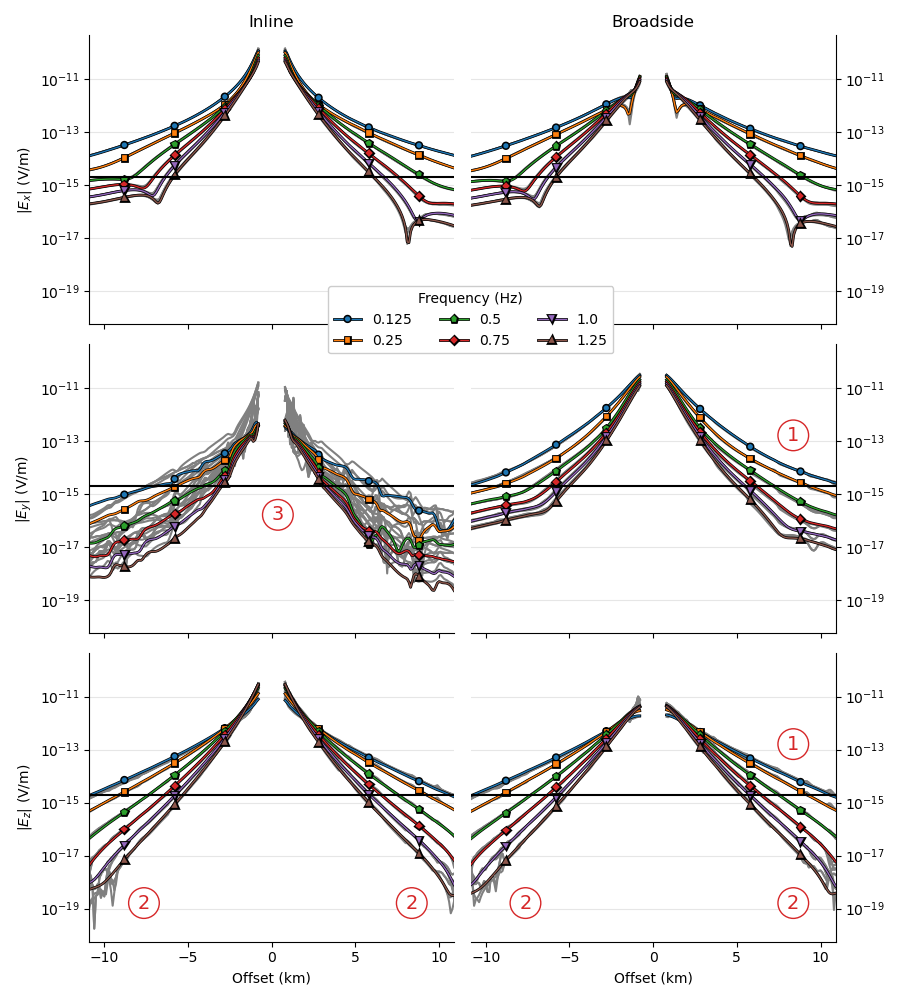

In [6]:
# Line styles for published data.
general = {'mec': 'k', 'mew': 0.2, 'lw': 1, 'markevery': (20, 30),
           'path_effects': [pe.Stroke(linewidth=2, foreground='k'), pe.Normal()]}
styles = {
    1.25: {'marker': '^', 'ms': 5, **general},
    1.0: {'marker': 'v', 'ms': 5, **general},
    0.75: {'marker': 'D', 'ms': 4, **general},
    0.5: {'marker': 'p', 'ms': 5, **general},
    0.25: {'marker': 's', 'ms': 4, **general},
    0.125: {'marker': 'o', 'ms': 4, **general},
}

# Initiate figure.
fig, axs = plt.subplots(3, 2, figsize=(9, 10), sharex=True, sharey=True)

# Loop over Inline/Broadside.
for iii, datname in enumerate(['data_il', 'data_bs']):

    # Get absolute values of this line.
    tdat = demod_line(data, datname)
    tegd = demod_line(egd, datname)
    tcst = demod_line(cst, datname)
    tptg = demod_line(ptg, datname)
    tspg = demod_line(spg, datname)

    # Loop over components Ex, Ey, Ez.
    for ii, comp in enumerate(data.components.values[:3]):

        # Get current axis.
        ax = axs[ii, iii]

        # Loop over frequencies for our codes.
        for i, freq in enumerate(data.freqs.values):

            # Loop over our codes.
            for ic, dat in enumerate([tegd, tcst, tptg, tspg]):
                ax.plot(offs[101::-1], dat[101::-1, i, ii], '.5')
                ax.plot(offs[102:], dat[102:, i, ii], '.5')

        # Loop over frequencies for published responses.
        for i, freq in enumerate(data.freqs.values):           
            ax.plot(offs[101::-1], tdat[101::-1, i, ii], f"C{i}", **styles[freq], label=f"{freq}")
            ax.plot(offs[102:], tdat[102:, i, ii], f"C{i}", **styles[freq])

        # Plot noise level.
        ax.axhline(2e-15, c='k')
        
        # Grid lines and yscale.
        ax.grid(axis='y', c='0.9')
        ax.set_yscale('log')
        
# Switch off spines and move ticks.
for ax in axs.ravel():
    ax.spines['top'].set_visible(False)
for ax in axs[:, 0].ravel():
    ax.spines['right'].set_visible(False)
for ax in axs[:, 1].ravel():
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position('right')
    ax.spines['left'].set_visible(False)

# Titles and labels.
axs[0, 0].set_title("Inline")
axs[0, 1].set_title("Broadside")
axs[2, 0].set_xlabel('Offset (km)')
axs[2, 1].set_xlabel('Offset (km)')
axs[0, 0].set_ylabel('$|E_x|$ (V/m)')
axs[1, 0].set_ylabel('$|E_y|$ (V/m)')
axs[2, 0].set_ylabel('$|E_z|$ (V/m)')

# Limits.
axs[0, 0].set_xlim([offs[0], offs[-1]])

# Annotate note-worthy points with numbers.
bbox = {'fontsize': 14, 'bbox': {"boxstyle" : "circle", 'ec': 'C3', 'fc': 'w'}}
axs[1, 1].annotate("1", (8, 1e-13), c='C3', **bbox)
axs[2, 1].annotate("1", (8, 1e-13), c='C3', **bbox)
axs[2, 0].annotate("2", (-8, 1e-19), c='C3', **bbox)
axs[2, 0].annotate("2", (8, 1e-19), c='C3', **bbox)
axs[2, 1].annotate("2", (-8, 1e-19), c='C3', **bbox)
axs[2, 1].annotate("2", (8, 1e-19), c='C3', **bbox)
axs[1, 0].annotate("3", (0, 1e-16), c='C3', **bbox)

# Tight layout.
fig.tight_layout()

# Add frequency legend.
axs[1, 1].legend(
    title='Frequency (Hz)', bbox_to_anchor=(0, 1.2),
    loc='upper center', borderaxespad=0., ncol=3, framealpha=1)

# Save and show.
fig.savefig(f'../manuscript/figures/results-marlim-responses.pdf', bbox_inches='tight')
fig.savefig(f'../manuscript/figures/results-marlim-responses.png', bbox_inches='tight', dpi=300)
fig.show()

## (2) Plot NRMSD with respect to published data

<IPython.core.display.Javascript object>


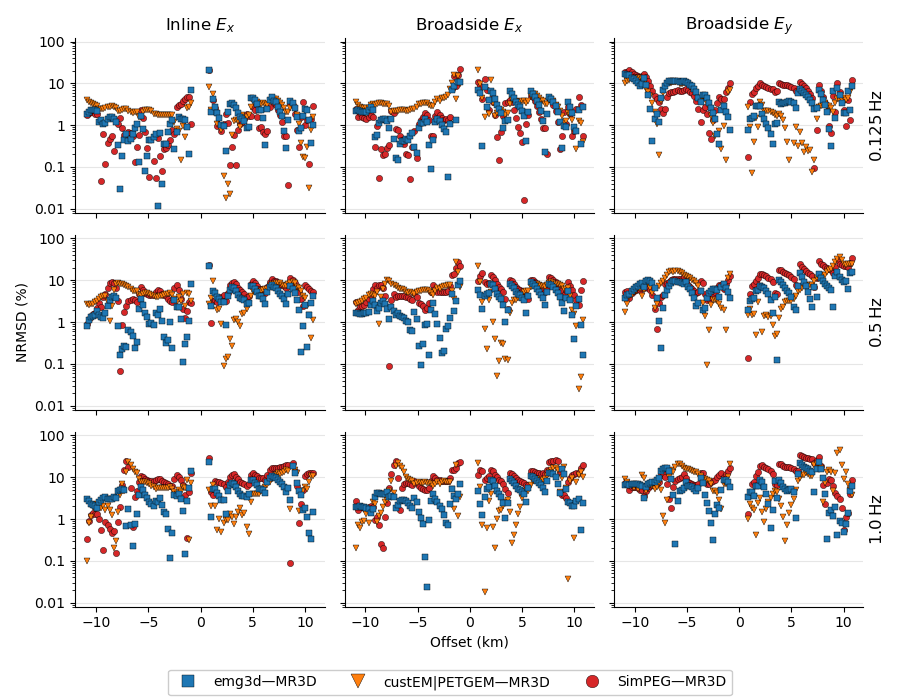

In [7]:
# Initiate figure.
fig, axs = plt.subplots(3, 3, figsize=(9, 7), sharex=True, sharey=True)

# Markers for scatter plots
marker = ['s', 'v', '^', 'o']
ms = [3.5, 4.5, 4.5, 4]

# Loop over Inline/Broadside
for iii, il_or_bs in enumerate(['data_il', 'data_bs']):

    # Get absolute values of this line (inline or broadside)
    tdat = demod_line(data, il_or_bs)
    tegd = demod_line(egd, il_or_bs)
    tcst = demod_line(cst, il_or_bs)
    tptg = demod_line(ptg, il_or_bs)
    tspg = demod_line(spg, il_or_bs)

    # Get component
    if il_or_bs == 'data_il':
        values = data.components.values[:1]  # Ex
    else:
        values = data.components.values[:2]  # Ex, Ey
        
    # Loop over frequencies
    for i, freq in enumerate(data.freqs.values[::2]):  # every 2nd
        fi = 2*i  # frequency-index, as we use every 2nd
        
        # Loop over components
        for ii, comp in enumerate(values):
            # Get current axis
            ax = axs[i, ii+iii]

            # Compute and plot NRMSD
            for ci, (cdat, cname) in enumerate(zip([tegd, tcst, tptg, tspg],
                                                   ['emg3d', 'custEM|PETGEM', 'notused', 'SimPEG'])):
                if ci == 2:
                    continue
                    
                nrmsd = 200*(abs(tdat[:, fi, ii]-cdat[:, fi, ii]) /
                             (tdat[:, fi, ii] + cdat[:, fi, ii]))
            
                ax.plot(offs[::2], nrmsd[::2], f"C{ci}{marker[ci]}",
                        mec='k', mew=0.3,
                        ms=ms[ci]+0.5, label=f"{cname}—MR3D", zorder=10-ci)
            
            # Axis labeling, scaling, etc
            ax.grid(axis='y', c='0.9')
            ax.set_yscale('log')
            ax.set_xticks([-10, -5, 0, 5, 10])

            ax.set_ylim([8e-3, 120])
            ax.set_yticks([0.01, 0.1, 1, 10, 100])
            ax.set_yticklabels(['0.01', '0.1', '1', '10', '100'])
            if ii+iii == 2:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(f"{freq}$\,$Hz", fontsize=12)
                   
# Switch off spines
for ax in axs.ravel():
    ax.spines['top'].set_visible(False)
for ax in axs[:, :].ravel():
    ax.spines['right'].set_visible(False)

# Titles, labels.            
axs[0, 0].set_title("Inline $E_x$")
axs[0, 1].set_title("Broadside $E_x$")
axs[0, 2].set_title("Broadside $E_y$")
axs[1, 0].set_ylabel('NRMSD (%)')
axs[2, 1].set_xlabel('Offset (km)')             

plt.tight_layout(rect=[0, 0.05, 1, 1])

axs[1, 2].legend(bbox_to_anchor=(0.5, 0.025), bbox_transform=fig.transFigure,
           loc='center', framealpha=1, ncol=4, markerscale=2)

plt.savefig(f'../manuscript/figures/results-marlim_2published.pdf', bbox_inches='tight')
plt.savefig(f'../manuscript/figures/results-marlim_2published.png', bbox_inches='tight', dpi=300)
plt.show()

## (3) Plot NRMSD with respect to each other

<IPython.core.display.Javascript object>


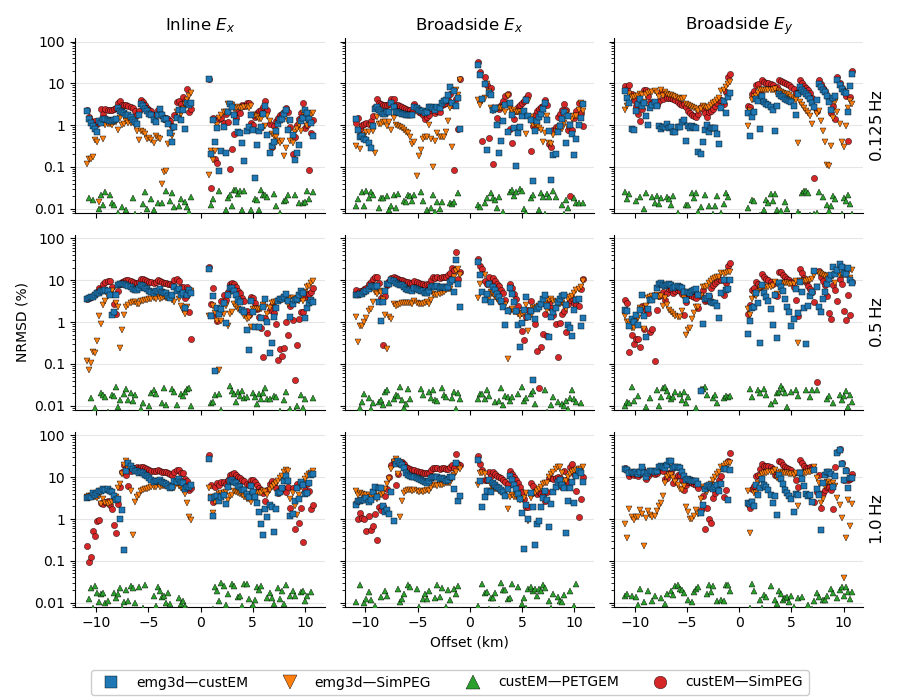

In [8]:
# Initiate figure.
fig, axs = plt.subplots(3, 3, figsize=(9, 7), sharex=True, sharey=True)

# Markers for scatter plots
marker = ['s', 'v', '^', 'o']
ms = [3.5, 4.5, 4.5, 4]

# Loop over Inline/Broadside
for iii, il_or_bs in enumerate(['data_il', 'data_bs']):

    # Get absolute values of this line (inline or broadside)
    tegd = demod_line(egd, il_or_bs)
    tcst = demod_line(cst, il_or_bs)
    tptg = demod_line(ptg, il_or_bs)
    tspg = demod_line(spg, il_or_bs)

    
    case_dict = {
        'emg3d—custEM': [tegd, tcst],  
        'emg3d—SimPEG': [tegd, tspg],
        'custEM—PETGEM': [tcst, tptg],
        'custEM—SimPEG': [tcst, tspg],
    }

    # Get component
    if il_or_bs == 'data_il':
        values = data.components.values[:1]  # Ex
    else:
        values = data.components.values[:2]  # Ex, Ey
        
    # Loop over frequencies
    for i, freq in enumerate(data.freqs.values[::2]):  # every 2nd
        fi = 2*i  # frequency-index, as we use every 2nd
        
        # Loop over components
        for ii, comp in enumerate(values):
            # Get current axis
            ax = axs[i, ii+iii]
            
            # Compute and plot NRMSD
            for ci, (cname, cdat) in enumerate(case_dict.items()):
                
                nrmsd = 200*(abs(cdat[0][:, fi, ii]-cdat[1][:, fi, ii]) /
                             (abs(cdat[0][:, fi, ii])+abs(cdat[1][:, fi, ii])))

                ax.plot(offs[::2], nrmsd[::2],
                        f"C{ci}{marker[ci]}",
                        mec='k', mew=0.3,
                        ms=ms[ci]+0.5, label=f"{cname}", zorder=10-ci)
            
            # Axis labeling, scaling, etc
            ax.grid(axis='y', c='0.9')
            ax.set_yscale('log')
            ax.set_xticks([-10, -5, 0, 5, 10])

            ax.set_ylim([8e-3, 120])
            ax.set_yticks([0.01, 0.1, 1, 10, 100])
            ax.set_yticklabels(['0.01', '0.1', '1', '10', '100'])
            if ii+iii == 2:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(f"{freq}$\,$Hz", fontsize=12)
                   
# Switch off spines
for ax in axs.ravel():
    ax.spines['top'].set_visible(False)
for ax in axs[:, :].ravel():
    ax.spines['right'].set_visible(False)

# Titles, labels.            
axs[0, 0].set_title("Inline $E_x$")
axs[0, 1].set_title("Broadside $E_x$")
axs[0, 2].set_title("Broadside $E_y$")
axs[1, 0].set_ylabel('NRMSD (%)')
axs[2, 1].set_xlabel('Offset (km)')             


plt.tight_layout(rect=[0, 0.05, 1, 1])

axs[1, 2].legend(bbox_to_anchor=(0.5, 0.025), bbox_transform=fig.transFigure,
           loc='center', framealpha=1, ncol=4, markerscale=2)

plt.savefig(f'../manuscript/figures/results-marlim_2ours.pdf', bbox_inches='tight')  
plt.savefig(f'../manuscript/figures/results-marlim_2ours.png', bbox_inches='tight', dpi=300)      
plt.show()

In [9]:
import scooby
scooby.Report(['xarray', 'h5netcdf'])

--------------------------------------------------------------------------------
  Date: Fri Jan 29 09:23:08 2021 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GB
       Environment : Jupyter

  Python 3.8.0 | packaged by conda-forge | (default, Nov 22 2019, 19:11:38)
  [GCC 7.3.0]

            xarray : 0.16.2
          h5netcdf : 0.8.1
             numpy : 1.19.5
             scipy : 1.6.0
           IPython : 7.19.0
        matplotlib : 3.3.3
            scooby : 0.5.6

  Intel(R) Math Kernel Library Version 2020.0.4 Product Build 20200917 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------